# This File Contains the Data Cleaning 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", None)

In [3]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

# grab data with csv

We can grab the data from the csvs that are in this directory (the data was originally taken from [here]('https://www.drivendata.org/competitions/66/flu-shot-learning/data/') )

In [4]:
training_features = pd.read_csv("../data/training_set_features.csv")
training_labels = pd.read_csv("../data/training_set_labels.csv")

# grab data from postrges

Can also grab the data out of a postgres database I set up (really just for practice)

In [7]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',  
    'dbname': 'fluvaccines',  
}

connection = pg.connect(**connection_args)

In [8]:
query = "SELECT * FROM targets;"

target_df = pd.read_sql(query, connection)

In [9]:
query = "SELECT * FROM features;"

features_df = pd.read_sql(query, connection)

In [10]:
features_df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,ace,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,None,None
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,None,None
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


# Start the cleaning

In [11]:
# Lets look at the size
training_features.shape

(26707, 36)

In [17]:
training_labels.shape

(26707, 3)

In [12]:
# combine into one dataframe
training_df = pd.merge(training_features, training_labels, on="respondent_id")
training_df.shape

(26707, 38)

In [19]:

training_df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
respondent_id                  26707 non-null int64
h1n1_concern                   26615 non-null float64
h1n1_knowledge                 26591 non-null float64
behavioral_antiviral_meds      26636 non-null float64
behavioral_avoidance           26499 non-null float64
behavioral_face_mask           26688 non-null float64
behavioral_wash_hands          26665 non-null float64
behavioral_large_gatherings    26620 non-null float64
behavioral_outside_home        26625 non-null float64
behavioral_touch_face          26579 non-null float64
doctor_recc_h1n1               24547 non-null float64
doctor_recc_seasonal           24547 non-null float64
chronic_med_condition          25736 non-null float64
child_under_6_months           25887 non-null float64
health_worker                  25903 non-null float64
health_insurance               14433 non-null float64
opinion_h1n1_vacc_effective  

There are a lot of null values in the health insurance column... lets inspect

In [187]:
column_name = []
h1n1_ratio_null = []
h1n1_ratio_no_null = []
h1n1_ratio = []
for c in training_df.columns:
    yes_h1n1_null = sum(training_df[training_df[c].isnull()]["h1n1_vaccine"]==1)
    no_h1n1_null = sum(training_df[training_df[c].isnull()]["h1n1_vaccine"]==0)
    
    yes_h1n1_no_null = sum(training_df[training_df[c].isnull() == False]["h1n1_vaccine"]==1)
    no_h1n1_no_null = sum(training_df[training_df[c].isnull() == False]["h1n1_vaccine"]==0)
    
    if no_h1n1_null > 0:
        column_name.append(c)
        h1n1_ratio_no_null.append(yes_h1n1_no_null/no_h1n1_no_null)
        h1n1_ratio_null.append(yes_h1n1_null/no_h1n1_null)

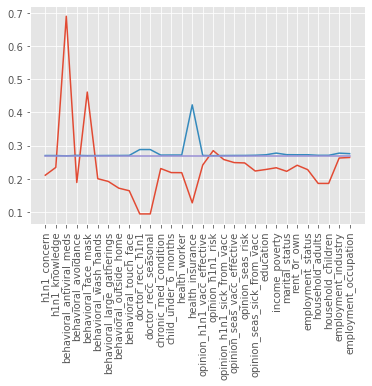

In [188]:
orig_ratio = len(training_df[training_df['h1n1_vaccine']==1].index)/len(training_df[training_df['h1n1_vaccine']==0].index)
plt.xticks(rotation=90)
plt.plot(column_name, h1n1_ratio_null)
plt.plot(column_name, h1n1_ratio_no_null)
plt.plot(column_name, [orig_ratio]*len(column_name));

The purple line is the ratio of no vaccinators to yes vaccinators across the whole dataset. The blue line is when nans are removed for each col. So it looks like the nans in doctor recc and health insurance actually make a difference. 

In [189]:
column_name = []
flu_ratio_null = []
flu_ratio_no_null = []
flu_ratio = []
for c in training_df.columns:
    yes_flu_null = sum(training_df[training_df[c].isnull()]["seasonal_vaccine"]==1)
    no_flu_null = sum(training_df[training_df[c].isnull()]["seasonal_vaccine"]==0)
    
    yes_flu_no_null = sum(training_df[training_df[c].isnull() == False]["seasonal_vaccine"]==1)
    no_flu_no_null = sum(training_df[training_df[c].isnull() == False]["seasonal_vaccine"]==0)
    
    if no_flu_null > 0:
        column_name.append(c)
        flu_ratio_no_null.append(yes_flu_no_null/no_flu_no_null)
        flu_ratio_null.append(yes_flu_null/no_flu_null)

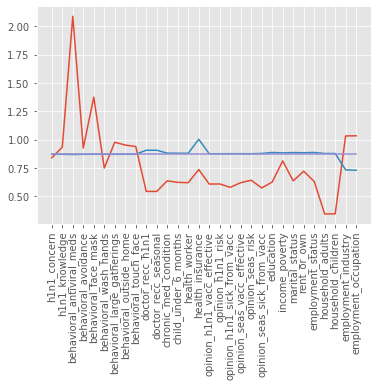

In [190]:
orig_ratio = len(training_df[training_df['seasonal_vaccine']==1].index)/len(training_df[training_df['seasonal_vaccine']==0].index)
plt.xticks(rotation=90)
plt.plot(column_name, flu_ratio_null)
plt.plot(column_name, flu_ratio_no_null)
plt.plot(column_name, [orig_ratio]*len(column_name));

# so health insur and doc recc n/a's do affect our ratios

We can not just remove or interpolate over the nan values

Lets look at different ratios for cleaning

In [14]:
got_h1n1 = training_df[training_df['h1n1_vaccine']==1]
no_h1n1 = training_df[training_df['h1n1_vaccine']==0]
got_flu = training_df[training_df['seasonal_vaccine']==1]
no_flu = training_df[training_df['seasonal_vaccine']==0]

In [15]:
all_resp = training_df.shape[0]

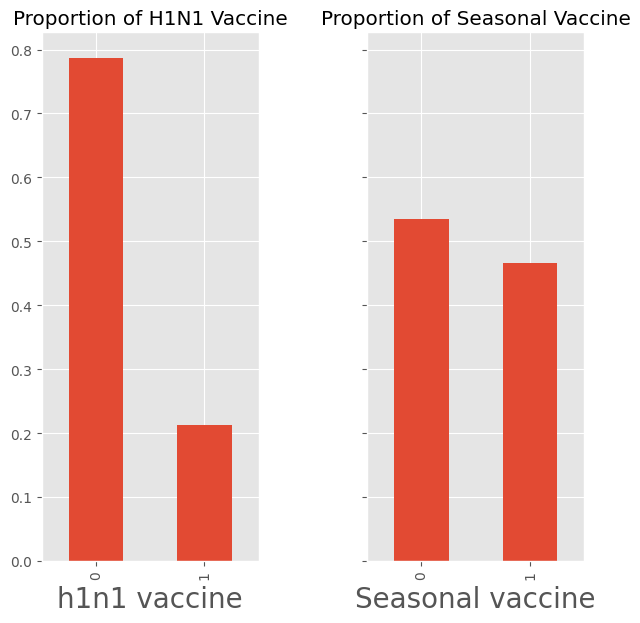

In [16]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7, 7), dpi=100)
plt.subplots_adjust(wspace=.5)

training_df['h1n1_vaccine'].value_counts().div(all_resp).plot.bar(title="Proportion of H1N1 Vaccine", ax=ax[0])

ax[0].set_xlabel("h1n1 vaccine", fontsize=20)

training_df['seasonal_vaccine'].value_counts().div(all_resp).plot.bar(title="Proportion of Seasonal Vaccine", ax=ax[1])

ax[1].set_xlabel("Seasonal vaccine", fontsize=20);
# plt.savefig('unbalanced_bar.png');

In [17]:
got_both = training_df[(training_df['h1n1_vaccine']==1) & training_df['seasonal_vaccine']==1]
got_h1n1_no_flu = training_df[(training_df['h1n1_vaccine']==1) & (training_df['seasonal_vaccine']==0)]
got_flu_no_h1n1 = training_df[(training_df['h1n1_vaccine']==0) & (training_df['seasonal_vaccine']==1)]
got_neither = training_df[(training_df['h1n1_vaccine']==0) & (training_df['seasonal_vaccine']==0)]

total_list = [got_neither.shape[0], got_flu_no_h1n1.shape[0], got_both.shape[0], got_h1n1_no_flu.shape[0]]
label_list = ["Neither", "Seasonal No H1N1", "Got Both", "H1N1 no Seasonal",]

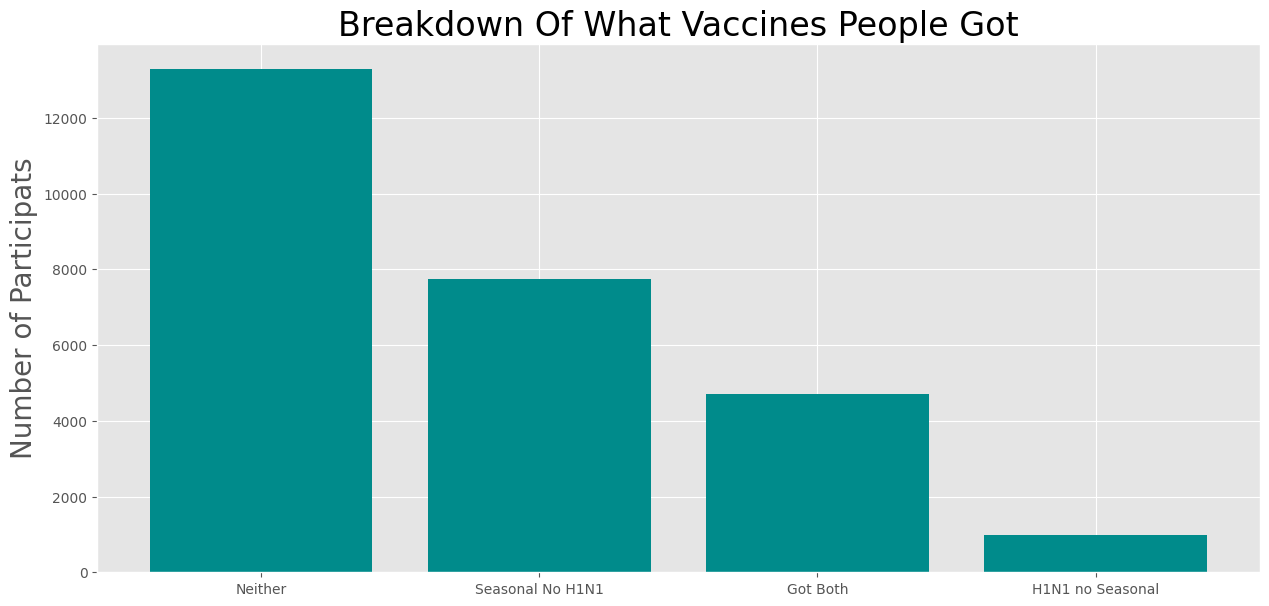

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=100)
plt.title("Breakdown Of What Vaccines People Got", fontsize=24)
plt.ylabel("Number of Participats", fontsize=20)
plt.bar(label_list, total_list, width=0.8, color='darkcyan')
plt.savefig('proportion_bar.png');

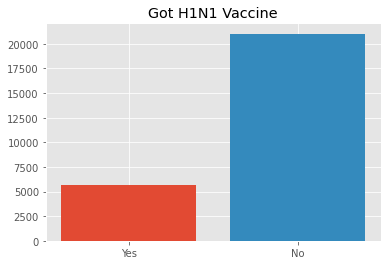

In [19]:


plt.title("Got H1N1 Vaccine")
plt.bar('Yes', len(got_h1n1.index))
plt.bar('No', len(no_h1n1.index));

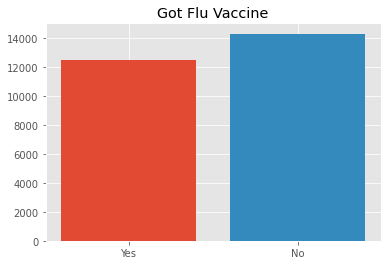

In [20]:
plt.title("Got Flu Vaccine")
plt.bar('Yes', len(got_flu.index))
plt.bar('No', len(no_flu.index));

So it looks like half the people got the flu vaccine, and much less got the h1n1 vaccine

Lets remove all n/a's and see what the breakdown is

In [21]:
training_no_na = training_df.dropna()

In [22]:
got_h1n1 = training_no_na[training_no_na['h1n1_vaccine']==1]
no_h1n1 = training_no_na[training_no_na['h1n1_vaccine']==0]
got_flu = training_no_na[training_no_na['seasonal_vaccine']==1]
no_flu = training_no_na[training_no_na['seasonal_vaccine']==0]

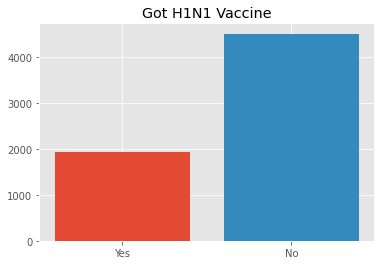

In [23]:
plt.title("Got H1N1 Vaccine")
plt.bar('Yes', len(got_h1n1.index))
plt.bar('No', len(no_h1n1.index));

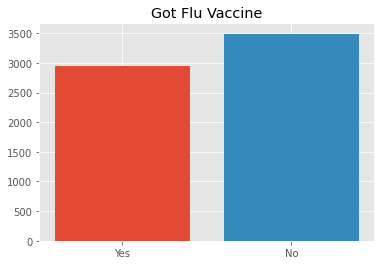

In [24]:
plt.title("Got Flu Vaccine")
plt.bar('Yes', len(got_flu.index))
plt.bar('No', len(no_flu.index));

The H1N1 relationship is way different

In [25]:
na_got_h1n1 = training_df[(training_df['health_insurance'].isna()) & (training_df['h1n1_vaccine']==1)]
na_no_h1n1 = training_df[(training_df['health_insurance'].isna()) & (training_df['h1n1_vaccine']==0)]

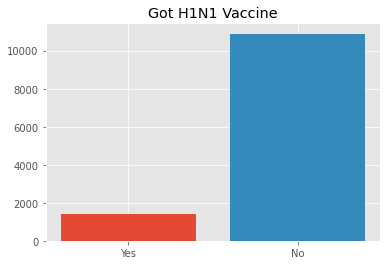

In [26]:
plt.title("Got H1N1 Vaccine")
plt.bar('Yes', len(na_got_h1n1.index))
plt.bar('No', len(na_no_h1n1.index));

if health insurance is n/a then they are very likely to not have h1n1

In [27]:
print("Percent of n/a health insurance that got h1n1: ", len(na_got_h1n1.index)/(len(na_got_h1n1.index)+len(na_no_h1n1.index)))
print("Percent of all that got h1n1: ", len(got_h1n1.index)/(len(got_h1n1.index)+len(no_h1n1.index)))

Percent of n/a health insurance that got h1n1:  0.11275867687795339
Percent of all that got h1n1:  0.30060587230076125


So a lot of the n/a's in health insurance actually affect the h1n1, lets make that column dummy

# make dummies for health insur and doctor rec

In [28]:
training_df_1 = pd.get_dummies(training_df, columns=['health_insurance'], dummy_na=True)
training_df_1 = pd.get_dummies(training_df_1, columns=['doctor_recc_h1n1'], dummy_na=True)
training_df_1 = pd.get_dummies(training_df_1, columns=['doctor_recc_seasonal'], dummy_na=True)

In [29]:
training_df_1.dropna().shape

(11626, 44)

Ok there are still quite a few rows with n/a (16K) so lets focus on employment_industry and employment_occupation

<AxesSubplot:>

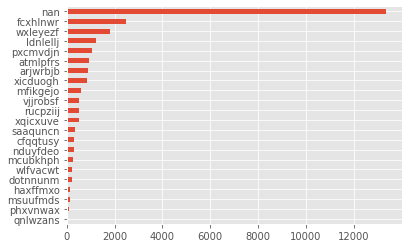

In [30]:
training_df_1.employment_industry.value_counts(dropna=False).sort_values().plot(kind = 'barh')

In [31]:
na_got_h1n1 = training_df[(training_df['employment_industry'].isna()) & (training_df['h1n1_vaccine']==1)]
na_no_h1n1 = training_df[(training_df['employment_industry'].isna()) & (training_df['h1n1_vaccine']==0)]

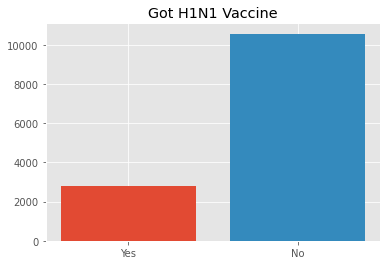

In [32]:
plt.title("Got H1N1 Vaccine")
plt.bar('Yes', len(na_got_h1n1.index))
plt.bar('No', len(na_no_h1n1.index));

In [33]:
print("Percent of n/a employment that got h1n1: ", len(na_got_h1n1.index)/(len(na_got_h1n1.index)+len(na_no_h1n1.index)))
print("Percent of all that got h1n1: ", len(got_h1n1.index)/(len(got_h1n1.index)+len(no_h1n1.index)))

Percent of n/a employment that got h1n1:  0.20787696924231058
Percent of all that got h1n1:  0.30060587230076125


<AxesSubplot:>

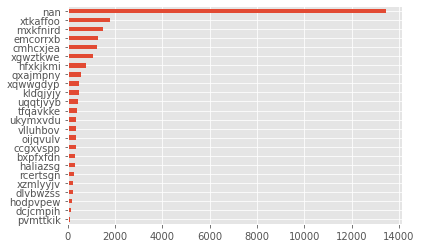

In [34]:
training_df_1.employment_occupation.value_counts(dropna=False).sort_values().plot(kind = 'barh')

im going to drop the employment columns as they dont seem to help and the majority is nan

In [35]:
no_occup_df = training_df_1.drop(labels=["employment_occupation", "employment_industry"], axis=1)

In [36]:
no_occup_df.dropna().shape[0] / training_df.shape[0]

0.7922642003968997

So we dropped about 20% of rows. ok for now

# lets look at categorical values

MAke a ton of categorical columns

In [37]:
no_occup_df.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'chronic_med_condition',
       'child_under_6_months', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
       'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'household_adults',
       'household_children', 'h1n1_vaccine', 'seasonal_vaccine',
       'health_insurance_0.0', 'health_insurance_1.0', 'health_insurance_nan',
       'doctor_recc_h1n1_0.0', 'doctor_recc_h1n1_1.0', 'doctor_recc_h1n1_nan',
       'doctor_recc_seasonal_0.0', 'doctor_recc_seasonal_1.0',
    

In [234]:
no_occup_df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,chronic_med_condition,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,health_insurance_0.0,health_insurance_1.0,health_insurance_nan,doctor_recc_h1n1_0.0,doctor_recc_h1n1_1.0,doctor_recc_h1n1_nan,doctor_recc_seasonal_0.0,doctor_recc_seasonal_1.0,doctor_recc_seasonal_nan
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0,0,1,0,1,0,0,1,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1,0,1,0,1,0,0,1,0,0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0,0,0,1,0,0,1,0,0,1
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1,0,0,1,1,0,0,0,1,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0,0,0,1,1,0,0,1,0,0


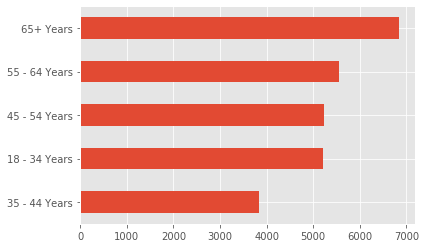

In [235]:
no_occup_df.age_group.value_counts(dropna=False).sort_values().plot(kind = 'barh')

In [236]:
age_mapper = {"65+ Years": 65, "55 - 64 Years": 55, "45 - 54 Years": 45, "18 - 34 Years": 18, "35 - 44 Years": 35}
no_occup_df["age_group"] = no_occup_df["age_group"].map(age_mapper)
no_occup_df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,chronic_med_condition,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,health_insurance_0.0,health_insurance_1.0,health_insurance_nan,doctor_recc_h1n1_0.0,doctor_recc_h1n1_1.0,doctor_recc_h1n1_nan,doctor_recc_seasonal_0.0,doctor_recc_seasonal_1.0,doctor_recc_seasonal_nan
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,55,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0,0,1,0,1,0,0,1,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,2.0,4.0,35,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1,0,1,0,1,0,0,1,0,0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,4.0,1.0,2.0,18,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0,0,0,1,0,0,1,0,0,1
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,5.0,5.0,4.0,1.0,65,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1,0,0,1,1,0,0,0,1,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,1.0,4.0,45,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0,0,0,1,1,0,0,1,0,0


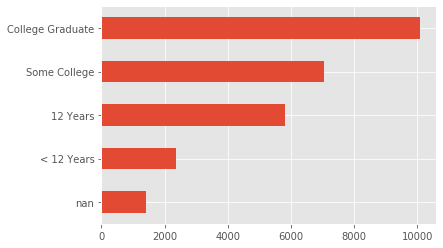

In [237]:
no_occup_df.education.value_counts(dropna=False).sort_values().plot(kind = 'barh')

In [244]:
education_mapper = {"< 12 Years": 10, "12 Years": 12, "Some College": 14, "College Graduate": 16}
no_occup_df["education"] = no_occup_df["education"].map(education_mapper)
no_occup_df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,chronic_med_condition,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,health_insurance_0.0,health_insurance_1.0,health_insurance_nan,doctor_recc_h1n1_0.0,doctor_recc_h1n1_1.0,doctor_recc_h1n1_nan,doctor_recc_seasonal_0.0,doctor_recc_seasonal_1.0,doctor_recc_seasonal_nan
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,55,10.0,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,0,0,0,1,0,1,0,0,1,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,4.0,4.0,4.0,2.0,4.0,35,12.0,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,0,1,0,1,0,1,0,0,1,0,0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,4.0,1.0,2.0,18,16.0,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,0,0,0,0,1,0,0,1,0,0,1
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,5.0,5.0,4.0,1.0,65,12.0,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,0,1,0,0,1,1,0,0,0,1,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,1.0,4.0,45,14.0,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,0,0,0,0,1,1,0,0,1,0,0


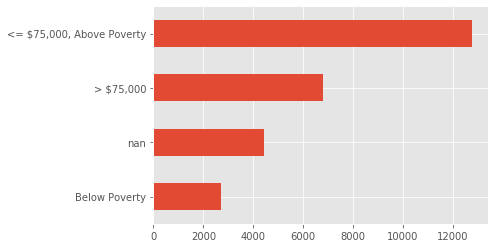

In [245]:
no_occup_df.income_poverty.value_counts(dropna=False).sort_values().plot(kind = 'barh')

In [247]:
no_occup_df = pd.get_dummies(no_occup_df, columns=['income_poverty'], dummy_na=True)

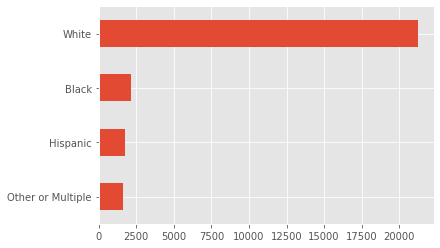

In [248]:
no_occup_df.race.value_counts(dropna=False).sort_values().plot(kind = 'barh')

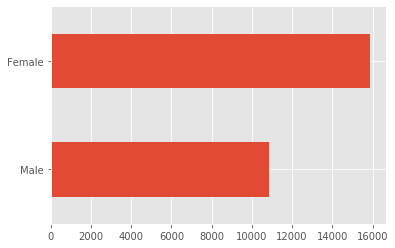

In [249]:
no_occup_df.sex.value_counts(dropna=False).sort_values().plot(kind = 'barh')

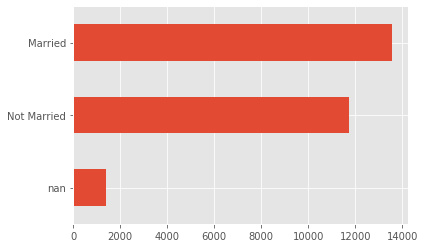

In [221]:
no_occup_df.marital_status.value_counts(dropna=False).sort_values().plot(kind = 'barh')

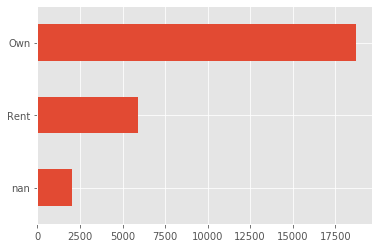

In [222]:
no_occup_df.rent_or_own.value_counts(dropna=False).sort_values().plot(kind = 'barh')

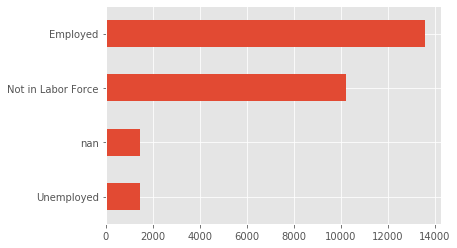

In [223]:
no_occup_df.employment_status.value_counts(dropna=False).sort_values().plot(kind = 'barh')

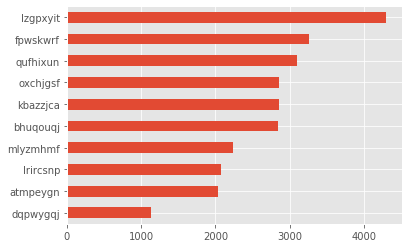

In [224]:
no_occup_df.hhs_geo_region.value_counts(dropna=False).sort_values().plot(kind = 'barh')

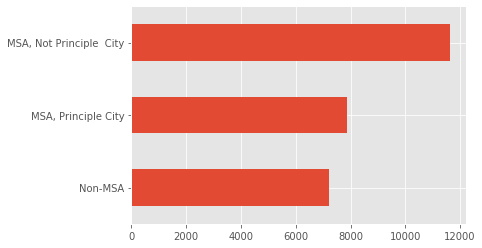

In [225]:
no_occup_df.census_msa.value_counts(dropna=False).sort_values().plot(kind = 'barh')

In [266]:
final_df = pd.get_dummies(no_occup_df, drop_first=True).dropna()

# So we ended up with about 90% of our data points after cleaning

In [267]:
final_df.shape[0]/training_df.shape[0]

0.9091249485153705

# Let's pickle this final dataframe

In [268]:
pd.to_pickle(final_df, "full_clean_df.pkl")